# Build a language model based on wikipedia in you language 

The notebooke includes the whole process but you will need to help the process if the following problem happens:  
-you internet connection is interrupted (stage 1)

-you run out of diskspace

-because of the huge memory consumption. creatig the databunch for the training requires lots of memory


In order ot handle these problemn the notebook is divided into stages. If the process is failes in a stage then you can resume the processing from the beginning of that stage by:
-restarting the kernel "Kernel"/Restart & Clear Output

-running the cells in stage 0: initialization

-running the cells from the start of the stage that failed 

# Stage 0: Initialisation
lang: You must set the parameter "lang" to the language you want to build a model for. Fx:

fr: for french

en: for english

de:for german

da: for danish 

etc.

pathData: You must se the location where you want your data stored using the parameter pathData. Consider using a ssd-rive

In [1]:
lang="en"

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.text import * 

from IPython.display import display, HTML
from pathlib import *
import re
import shutil

In [4]:
pathData       = Path("../../data/nlp")
path           = pathData / lang
pathDump       = path/"wiki-dump"
pathJson       = path/"wiki-json"

pathTrainValid = path/"wiki-train_valid"
pathTxt        = pathTrainValid/"txt"
pathToks       = pathTrainValid/"toks"
pathcsv        = pathTrainValid/"wiki.csv"

cache_name   = "sp-model"
pathVocab    = pathTrainValid / cache_name

# requried libraries: 
conda install -c anaconda psutil 

conda install -c anaconda git 

#conda install -c menpo wget 
conda install curl


# Stage 1: download the selected language from wikipedia and convert the articles to json

In [5]:
if len(list(pathDump.glob("*.bz2")))==0:
    pathDump.mkdir(parents=True,exist_ok=True)
    #fn  = f"{lang}wiki-latest-pages-articles.xml.bz2"
    fn  = f"{lang}wiki-latest-pages-articles-multistream.xml.bz2"
    url = f"https://dumps.wikimedia.org/{lang}wiki/latest/{fn}"
    #cmd = f"wget -c --no-check-certificate --show-progress {str(url)} -P {str(pathDump)}"
    cmd = f'curl -k -C - -o "{str(pathDump/fn)}" "{str(url)}"'
    print(f"If the command fails in the notebook then copy the command and run it in the terminal:{cmd}")
    ! $cmd

# Stage 2: Convert wikipedia dump to articles in json

In [6]:
pathWikiExtractor = Path("../wikiextractor")

In [7]:
if not pathJson.exists():
    !git clone https://github.com/attardi/wikiextractor.git $pathWikiExtractor
    cmd = f"cd {str(pathWikiExtractor)} && python setup.py install"
    ! $cmd

In [8]:
%%time
if not pathJson.exists():
    #extracting the json-files. This takes about 1 hour for french with files read from and saved to a ssd hardrive 
    fn_wikidump = list(pathDump.iterdir())[0]
    #cmd = f"cd {str(pathWikiExtractor)} && python WikiExtractor.py -o {str(pathJson)} --json --processes {defaults.cpus} -q --filter_disambig_pages --no-templates --discard_elements gallery,timeline,noinclude {str(fn_wikidump)}"
    #cmd = f"cd {str(pathWikiExtractor)} && python WikiExtractor.py -o {str(pathJson)} --json --processes {defaults.cpus} -q --filter_disambig_pages --discard_elements gallery,timeline,noinclude {str(fn_wikidump)}"
    cmd = f"cd {str(pathWikiExtractor)} && python WikiExtractor.py -o {str(pathJson)} --json --processes {defaults.cpus} -q --filter_disambig_pages --no-templates --discard_elements gallery,timeline,noinclude {str(fn_wikidump)}"
    print(f"If WikiExtractor fails in the notebook then copy the command and run it in the terminal:{cmd}")
    ! $cmd

Wall time: 0 ns


# Stage 3: building a vocabulary using sentencepiece

Now we separate the title of the wikipedia section from text section that we keep. 

In order to makes a first reduction on the number of section we clean the text with the preprocessing rules from fastai and ignore text with less than "minWords"

You must set the lenght of the shortes sections to keep using the parameter "minWords"

In [9]:
minWords  = 1
chunksize = 25000

In [10]:
!pip install sentencepiece

In [11]:
from fastai_sentencepiece import *
from filetokenizer import *

In [12]:
data = None
if not pathTxt.exists():
    swm = SentencepieceWikiVocab(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab)    
    %time swm.wikijson2TrainingData()
    %time data = pd.read_csv(pathcsv)
    gc.collect()

In [13]:
if data is not None:
    percentiles = 0.01 * np.asarray([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 
                                     1,2,3,4,10,20, 50, 75, 90, 95, 96, 97, 98, 
                                     99, 99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9,99.99]) 
    %time display(data.describe(percentiles,include=[np.number]))
    print(f"data:{data.shape}")

In [14]:
if data is not None:
    lpl = data.alpha_r3.values
    #ix = lpl<8
    ix = np.logical_and(lpl>.17,lpl<.18)
    data_empty = data[ix]
    print(f"data_empty:{data_empty.shape}")
    
    percentiles = 0.01 * np.asarray([1,10,25, 50, 75, 90, 99])     
    %time data_empty.describe(percentiles,include=[np.number])
    display(data_empty)
    print(data_empty.text.head().values)
    print(data_empty.text.tail().values)
    gc.collect()

In [15]:
if not (pathVocab/"m.model").exists():
    swm = SentencepieceWikiVocab(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab)
    %time swm.trainVocabulary()

In [16]:
if not (pathVocab/"itos.pkl").exists():
    swm = SentencepieceWikiVocab(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab)
    swm.convertSPVocab2FastaiVocab()

# Show some examples using the vocabulary

In [17]:
swm = SentencepieceWikiVocab(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab)
sp  = spm.SentencePieceProcessor()
sp.Load(str(pathVocab / "m.model"))
print("\nSize of vocabulary:",sp.GetPieceSize())

control_symbols = ["<unk>","xxbos","xxeos","xxpad"]
print(f"Control symbol:")
for s in control_symbols: print(f"{s}({sp.PieceToId(s)})")

print(f"\nUser defined symbols:")
for s in swm.getUserdefinedSymbols():print(f"{s}({sp.PieceToId(s)})")

sentence = "She is tall. He is small".lower()
print(f"Sentence:          {sentence}")
print(f"Sentence as pieces:{sp.EncodeAsPieces(sentence)}")
print(f"Sentence as ids:   {sp.EncodeAsIds(sentence)}")
print(f"Sentence from ids:   {sp.DecodeIds(sp.EncodeAsIds(sentence))}")


Size of vocabulary: 4000
Control symbol:
<unk>(0)
xxbos(1)
xxeos(2)
xxpad(3)

User defined symbols:
xxfld(4)
xxmaj(5)
xxup(6)
xxrep(7)
xxwrep(8)
0(9)
1(10)
2(11)
3(12)
4(13)
5(14)
6(15)
7(16)
8(17)
9(18)
°(19)
%(20)
$(21)
§(22)
£(23)
€(24)
((25)
)(26)
<(27)
>(28)
"(29)
'(30)
“(31)
”(32)
‘(33)
’(34)
!(35)
,(57)
;(36)
:(37)
.(38)
•(39)
—(40)
|(41)
\(42)
/(43)
*(44)
+(45)
-(46)
=(47)
⁄(48)
′(49)
_(50)
#(51)
&(52)
?(53)
Sentence:          she is tall. he is small
Sentence as pieces:['▁she', '▁is', '▁tall', '.', '▁he', '▁is', '▁small']
Sentence as ids:   [126, 66, 3135, 38, 74, 66, 555]
Sentence from ids:   she is tall. he is small


# Prepare training of the language model

# LM Training
Set the minimum number of tokens for the sections that we shall retain

In [18]:
spt_func  = partial(SentencepieceTokenizer.create, pathVocab=pathVocab)
spt_func.__name__ = SentencepieceTokenizer.__name__
spt       = spt_func(lang="en")

unk_idx,pad_idx = spt.vocab().numericalize([text.transform.UNK])[0], spt.vocab().numericalize([text.transform.PAD])[0]
print(f"unk_idx:{unk_idx} pad_idx:{pad_idx}")
vocab,max_vocab = spt.vocab(), len(spt.vocab().itos)
trainTokenizer  = SPFileTokenizer(pathToks/"train", spt_func,"en",vocab,n_cpus=max(defaults.cpus-1,1))
validTokenizer  = SPFileTokenizer(pathToks/"valid", spt_func,"en",vocab,n_cpus=max(defaults.cpus-1,1))

unk_idx:0 pad_idx:3


In [19]:
files   = np.asarray( list(pathTxt.glob("*.txt")) )
nrows   = len(files)
split   = 0.2
splitindex, index = int(nrows*split+.5), np.random.permutation(np.arange(nrows)) 

chunksize=0

trainList = TextList( files[:-splitindex], vocab=vocab, pad_idx=pad_idx, 
                      processor=[SPFileTokenizeProcessor(tokenizer=trainTokenizer, 
                                                       chunksize=chunksize, mark_fields=False)])

validList = TextList( files[-splitindex:], vocab=vocab, pad_idx=pad_idx, 
                      processor=[SPFileTokenizeProcessor(tokenizer=validTokenizer, 
                                                       chunksize=chunksize, mark_fields=False)])


In [20]:
if not (pathToks/"train").exists():
    %time trainList.process()
    trainList=None
    gc.collect()    

In [21]:
if not (pathToks/"valid").exists():
    %time p = validList.process()
    validList=None
    gc.collect()

# The following cells are used to find macUnk, minToks and maxToks.
The 4 cells were deactivate after deciding on these values

In [22]:
check_statistics=False
if check_statistics:
    %time trainIDS = trainTokenizer.getIds()
    %time validIDS = validTokenizer.getIds()
else:
    trainIDS = validIDS = None

In [23]:
#how much do we loos by removing sentences with unks
if trainIDS is not None:
    unkPrSentence        = np.asarray([np.sum(s==unk_idx) for s in trainIDS],dtype=np.int)
    percentUnkPrSentence = np.asarray([np.sum(s==unk_idx)/len(s) for s in trainIDS])
    percent              = np.asarray([0, 50, 75, 90, 97, 98.5, 99, 99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9, 99.95,  99.99, 100]) 
    percentiles          = np.percentile(unkPrSentence,percent).astype(np.int)
    print("unkPrSentence %  percentile ")
    for i in range(len(percent)):print(f"{percent[i]}  {percentiles[i]}")   

    unkPrSentence=None
    gc.collect()

In [24]:
if trainIDS is not None:
    print(f"Traning:    number of arrays:{len(trainIDS)} - number of ids:{sum(len(ids) for ids in trainIDS)}")
    print(f"Validation: number of arrays:{len(validIDS)} - number of ids:{sum(len(ids) for ids in validIDS)}")

    #Analyse the distribution of the legnth of tokens sequences in the ragged/jagged array of tokes
    sectionlengths = np.asarray([len(s) for s in trainIDS],dtype=np.int32)
    plt.hist(sectionlengths[sectionlengths<500], 250, density=True, facecolor='g', alpha=0.75)
    np.histogram(sectionlengths[sectionlengths<1000],50)

    print(f"Lenght of token rags min:{min(sectionlengths)} max:{np.max(sectionlengths)} - median:{np.median(sectionlengths)}")
    print(f"Lenght of token rags mean:{np.mean(sectionlengths)} std:{np.std(sectionlengths)}")

    percent     = np.asarray([ 0, 0.11, 0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9, 1, 1.5, 2, 25,50,75,90,97,99,99.5,99.9,99.99,100]) # %np.arange(101,dtype=np.int)
    percentiles = np.percentile(sectionlengths,percent).astype(np.int)
    print("%  percentile")
    for i in range(len(percent)):print(f"{percent[i]}  {percentiles[i]}")
    minToks = percentiles[np.where( percent==0.11 )[0][0]]
    maxToks = percentiles[np.where( percent==99.99 )[0][0]]
    print(f"\nminToks:{minToks} maxToks:{maxToks}")
    print(f"rags <= minToks:{np.sum(sectionlengths <= minToks)}")
    print(f"rags >= maxToks:{np.sum(sectionlengths >= maxToks)}")

    sectionlengths = trainIDS = validIDS = None
    gc.collect()

In [25]:
maxUnks,minToks,maxToks = 0,14,500

%time trainIDS = trainTokenizer.getIds(minToks, maxToks, maxUnks, unk_idx=unk_idx)
%time validIDS = validTokenizer.getIds(minToks, maxToks, maxUnks, unk_idx=unk_idx)

Wall time: 3min 5s
Wall time: 41.8 s


Traning:    number of arrays:24922316 - number of ids:2862637393
Validation: number of arrays:5714278 - number of ids:662367582
Lenght of token rags min:14 max:500 - median:94.0


7

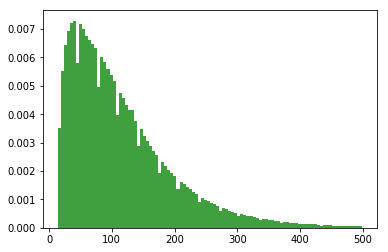

In [26]:
print(f"Traning:    number of arrays:{len(trainIDS)} - number of ids:{sum(len(ids) for ids in trainIDS)}")
print(f"Validation: number of arrays:{len(validIDS)} - number of ids:{sum(len(ids) for ids in validIDS)}")
sectionlengths = np.asarray([len(s) for s in trainIDS],dtype=np.int32)
plt.hist(sectionlengths[sectionlengths<maxToks], 100, density=True, facecolor='g', alpha=0.75)
np.histogram(sectionlengths[sectionlengths<1000],50)
print(f"Lenght of token rags min:{min(sectionlengths)} max:{np.max(sectionlengths)} - median:{np.median(sectionlengths)}")
gc.collect()

In [27]:
#shuffle the rags so that any subset is composed of similar text

In [58]:
#from languagemodelloader import *

#nTrainToks, nValidToks = int(5e6),int(2e6)
#nTrainToks, nValidToks = int(5e5),int(2e5)
nTrainToks, nValidToks = int(2e5),int(1e4)
#nTrainToks, nValidToks = int(5e3),int(1e3)
if nTrainToks>0 and nValidToks>0:
    trainIDS_ = trainIDS[0:nTrainToks]
    validIDS_ = validIDS[0:nValidToks]
else:
    trainIDS_ = trainIDS
    validIDS_ = validIDS

#dblm = TextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS_, validIDS_, bptt=70, bs=32, num_workers=0, lengths=lengths)
%time dblm = TextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS_, validIDS_, bptt=94, bs=128, num_workers=0, no_check=True)
nTrainToks, nValidToks

Wall time: 22.9 ms


(200000, 10000)

In [59]:
dblm.show_batch()

idx,text
0,"anarchism is a political philosophy that advocates self-governed societies based on voluntary, cooperative institutions, rejecting unjust hierarchy. these institutions are often described as stateless societies, although several authors have defined them more specifically as institutions based on non-hierarchical or free associations. anarchism holds capitalism, the state,"
1,"by a passing shot or lob if the opponent was fast enough to retrieve it. agassi was raised on hardcourts, but found much of his early major-tournament success on the red clay of roland garros, reaching two consecutive finals there early in his career. despite grass being his worst surface, his first major win was at the slick"
2,"its letters), the closest match being a verb meaning to split a word into its syllables. similarly, the italian verb corresponding to 'spell (out)', ""compitare"", is unknown to many italians because spelling is usually trivial, as italian spelling is highly phonemic. in standard spanish, one can tell the"
3,"unesco proclaimed the azerbaijani mugham tradition a masterpiece of the oral and intangible heritage of humanity on 7 november 2003. meykhana is a kind of traditional azerbaijani distinctive folk unaccompanied song, usually performed by several people improvising on a particular subject. ashiq combines"
4,"tailed philological analysis, babcock concludes that the account of natural death given by priscus was an ecclesiastical ""cover story"", and that emperor marcian (who ruled the eastern roman empire from 450 to 457) was the political force behind attila's death. jordanes recounts: attila's sons"


In [60]:
print(awd_lstm_lm_config)

{'emb_sz': 400, 'n_hid': 1150, 'n_layers': 3, 'pad_token': 1, 'qrnn': False, 'bidir': False, 'hidden_p': 0.020000000000000004, 'input_p': 0.04000000000000001, 'embed_p': 0.004, 'weight_p': 0.03}


In [61]:
default_dropout = {'language': np.array([0.25, 0.1, 0.2, 0.02, 0.15]),
                   'classifier': np.array([0.4,0.5,0.05,0.3,0.4])}
dps      = default_dropout["language"]
input_p  = dps[0] 
output_p = dps[1] 
weight_p = dps[2] 
embed_p  = dps[3] 
hidden_p = dps[4] 
out_bias = True

cfg = awd_lstm_lm_config.copy()
print(cfg)
cfg['pad_token'],cfg['qrnn'],cfg['tie_weights'] =\
     pad_idx,         False,      True
cfg['output_p'], cfg['input_p'],cfg['output_p'],cfg['weight_p'],cfg['embed_p'],cfg['hidden_p'],cfg['out_bias']=\
     output_p,        input_p,       output_p,       weight_p,       embed_p,       hidden_p,       out_bias
print(cfg)
drop_mult=.2
awd_lstm_lm_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=1, qrnn=False, bidir=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
%time learn = language_model_learner(dblm, AWD_LSTM,config=cfg, drop_mult=drop_mult, pretrained=False, callback_fns=ShowGraph )
#callback_fns=PeakMemMetric)

{'emb_sz': 400, 'n_hid': 1150, 'n_layers': 3, 'pad_token': 1, 'qrnn': False, 'bidir': False, 'hidden_p': 0.020000000000000004, 'input_p': 0.04000000000000001, 'embed_p': 0.004, 'weight_p': 0.03}
{'emb_sz': 400, 'n_hid': 1150, 'n_layers': 3, 'pad_token': 3, 'qrnn': False, 'bidir': False, 'hidden_p': 0.15, 'input_p': 0.25, 'embed_p': 0.02, 'weight_p': 0.2, 'tie_weights': True, 'output_p': 0.1, 'out_bias': True}
Wall time: 177 ms


In [62]:
gc.collect()
%time learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Wall time: 23.7 s


3

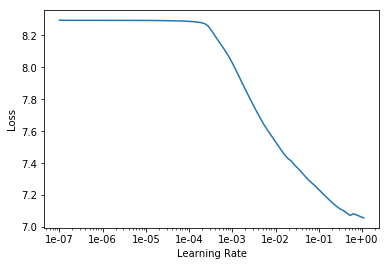

In [ ]:
learn.recorder.plot(skip_start=0, skip_end=11)
gc.collect()

epoch,train_loss,valid_loss,accuracy
1,4.596995,4.632120,0.232422
2,3.663674,3.907927,0.305554
3,3.416656,3.711513,0.325941
4,3.305673,3.628349,0.334374
5,3.212764,3.570199,0.343381


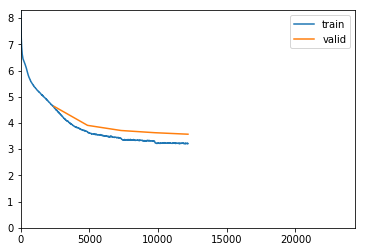

In [ ]:
from fastai.text import * 
#%load_ext line_profiler
#%time learn.fit_one_cycle(1,2e-3, moms=(0.8,0.7))
#%time learn.fit_one_cycle(1,4e-3, moms=(0.95,0.85))
#%time learn.fit_one_cycle(20,4e-3, moms=(0.8,0.7), wd=1e-7)
#learn.clip_grad(clip=0.12)
#%time learn.fit_one_cycle(1,5e-3, moms=(0.99,0.2))
epochs=10
#%time learn.fit_one_cycle(cyc_len=epochs, max_lr=5e-3, moms=(0.99,0.7))
#%time learn.fit_one_cycle(cyc_len=epochs, max_lr=8e-3, moms=(0.95,0.5)) #256,384
%time learn.fit_one_cycle(cyc_len=epochs, max_lr=2e-3, moms=(0.8,0.7)) #256,384

In [ ]:
#remember to update the last validation loss to get your perplexity score
print( f"Perplexity: {exp(3.257929)}") #best: 3.221317
trainTokens={sum(len(s) for s in trainIDS_)}
print( f"Number of tokens in trainingdata:   {sum(len(s) for s in trainIDS_)}")
print( f"Number of tokens in validationdata: {sum(len(s) for s in validIDS_)}")

In [ ]:
learn.save(f'lm-32k-sentencepiece-{epochs}-{len(trainIDS_)}-{len(validIDS_)} dropout{int(round(100*drop_mult))} ')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
losses = learn.recorder.losses
len(losses)

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
#TEXT = "if i knew back then what i know now," #  i would not agree # seen in polval
TEXT = "i liked this movie because"
#TEXT = "anarchy is a political philosophy that"
N_WORDS = 40
N_SENTENCES = 5

In [ ]:
print(("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES))).replace("▁",""))

In [ ]:
print(("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.25) for _ in range(N_SENTENCES))).replace("▁",""))

In [ ]:
pd_losses = pd.DataFrame(data=losses)
pd_losses.to_csv(pathTrainValid/"losses_steps.csv", header="losses")